In [134]:
import numpy as np
import pandas as pd
country=['Taiwan','Australia','Ireland','Australia','Ireland','Taiwan','Taiwan','Taiwan','Australia','Ireland','Australia']
age=[25,30,45,35,22,36,35,22,36,45,35]
salary=[20000,32000,59000,60000,43000,52000,60000,43000,32000,59000,60000]
road=['xin','san','xin','san','lu','xin','san','xin','san','xin','san']
ans=[1,0,0,1,0,0,1,1,1,0,0]
dic={'Country':country,'Age':age,'Salary':salary,'road':road,'ans':ans}
data=pd.DataFrame(dic)
data['Country']=data['Country'].astype('category')
data['road']=data['road'].astype('category')
data

,Country,Age,Salary,road,ans
0,Taiwan,25,20000,xin,1
1,Australia,30,32000,san,0
2,Ireland,45,59000,xin,0
3,Australia,35,60000,san,1
4,Ireland,22,43000,lu,0
5,Taiwan,36,52000,xin,0
6,Taiwan,35,60000,san,1
7,Taiwan,22,43000,xin,1
8,Australia,36,32000,san,1
9,Ireland,45,59000,xin,0


In [135]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 5 columns):
Country    11 non-null category
Age        11 non-null int64
Salary     11 non-null int64
road       11 non-null category
ans        11 non-null int64
dtypes: category(2), int64(3)
memory usage: 622.0 bytes


In [22]:
'''
pd.get_dummies(data)
'''

,Age,Salary,ans,Country_Australia,Country_Ireland,Country_Taiwan,road_lu,road_san,road_xin
0,25,20000,1,0,0,1,0,0,1
1,30,32000,0,1,0,0,0,1,0
2,45,59000,0,0,1,0,0,0,1
3,35,60000,1,1,0,0,0,1,0
4,22,43000,0,0,1,0,1,0,0
5,36,52000,0,0,0,1,0,0,1


In [23]:
'''
pd.get_dummies(data,drop_first=True)
'''

,Age,Salary,ans,Country_Ireland,Country_Taiwan,road_san,road_xin
0,25,20000,1,0,1,0,1
1,30,32000,0,0,0,1,0
2,45,59000,0,1,0,0,1
3,35,60000,1,0,0,1,0
4,22,43000,0,1,0,0,0
5,36,52000,0,0,1,0,1


In [113]:
data_get_dummies=pd.get_dummies(data,drop_first=True)
dataY=data_get_dummies.pop('ans')

In [136]:
dataY=data.pop('ans')

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [137]:
X_train, X_test, y_train, y_test = train_test_split(data, 
                                    dataY, test_size=0.33, 
                                    random_state=2018, stratify=dataY)
k_fold = StratifiedKFold(n_splits=2,shuffle=True,random_state=2018)

In [48]:
from sklearn.metrics import log_loss 

In [24]:
import lightgbm as lgb

In [40]:
params_lightGB = {
    'task': 'train',
    'application':'binary',
    'num_class':1,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'metric_freq':50,
    'is_training_metric':False,
    'max_depth':4,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'bagging_seed': 2018,
    'verbosity': 0,
    'num_threads':16
}

In [138]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],
                                index=y_train.index,columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),
                                          y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
        X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
        y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold, params={'verbose': -1})
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train, params={'verbose': -1})
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=100,#2000
                   valid_sets=lgb_eval, early_stopping_rounds=20, verbose_eval=False)#500
    
    loglossTraining = log_loss(y_train_fold, \
                gbm.predict(X_train_fold, num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = \
        gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, \
        predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    print('Training Log Loss: ', loglossTraining)
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLightGBMGradientBoosting = \
    log_loss(y_train, predictionsBasedOnKFolds.loc[:,'prediction'])
print('LightGBM Gradient Boosting Log Loss: ', loglossLightGBMGradientBoosting)

Training Log Loss:  0.6365141682948128
Training Log Loss:  0.6365141682948128
CV Log Loss:  0.7520386983881371
Training Log Loss:  0.6931471805599453
Training Log Loss:  0.6931471805599453
CV Log Loss:  0.6931471805599453
LightGBM Gradient Boosting Log Loss:  0.7267994764617691


In [63]:
from sklearn.metrics import precision_recall_curve, average_precision_score 
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

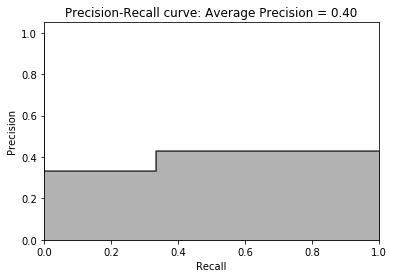

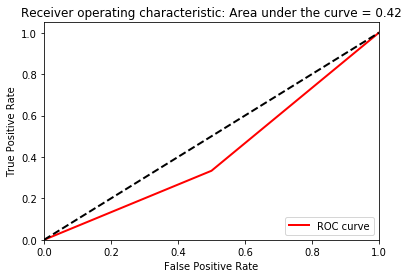

In [140]:
preds = pd.concat([y_train,predictionsBasedOnKFolds.loc[:,'prediction']], axis=1)
preds.columns = ['trueLabel','prediction']
predictionsBasedOnKFoldsLightGBMGradientBoosting = preds.copy()

precision, recall, thresholds = \
    precision_recall_curve(preds['trueLabel'],preds['prediction'])
average_precision = \
    average_precision_score(preds['trueLabel'],preds['prediction'])

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

In [143]:
#NEW DATA
country=['Ireland','Taiwan','Taiwan']
age=[25,30,45]
salary=[43000,52000,60000]
road=['xin','san','xin']
#ans=[1,0,0,1,0,0,1,1,1,0,0]
newdic={'Country':country,'Age':age,'Salary':salary,'road':road}
newdata=pd.DataFrame(newdic)
newdata['Country']=newdata['Country'].astype('category')
newdata['road']=newdata['road'].astype('category')
newdata

,Country,Age,Salary,road
0,Ireland,25,43000,xin
1,Taiwan,30,52000,san
2,Taiwan,45,60000,xin


In [72]:
'''
newdata_get_dummies= pd.get_dummies(newdata)
newdata_get_dummies
'''

,Age,Salary,Country_Ireland,Country_Taiwan,road_san,road_xin
0,25,43000,1,0,0,1
1,30,52000,0,1,1,0
2,45,60000,0,1,0,1


In [145]:
newdata_predict=pd.DataFrame(gbm.predict(newdata, num_iteration=gbm.best_iteration),columns={'predict'})
pd.concat([newdata,newdata_predict],axis=1)

,Country,Age,Salary,road,predict
0,Ireland,25,43000,xin,0.5
1,Taiwan,30,52000,san,0.5
2,Taiwan,45,60000,xin,0.5


In [147]:
gbm.feature_importance()

array([0, 0, 0, 0])

In [97]:
#unsupervised_learning
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
    average_precision = \
        average_precision_score(preds['trueLabel'],preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
    {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: \
    Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds
    
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)

In [102]:
import seaborn as sns
color = sns.color_palette()

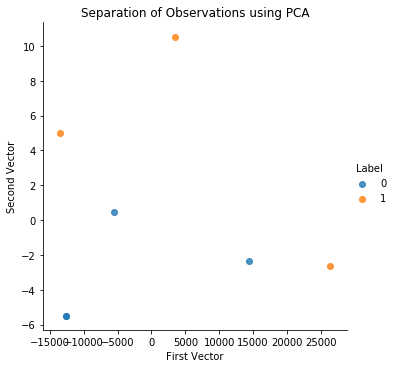

In [103]:
# 2 principal components
from sklearn.decomposition import PCA

n_components = 2
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, \
                                   index=X_train.index)

scatterPlot(X_train_PCA, y_train, "PCA")

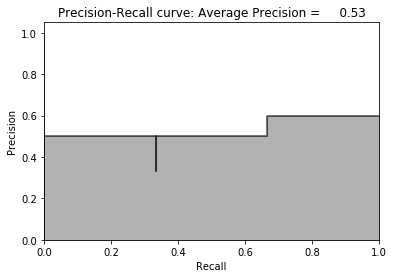

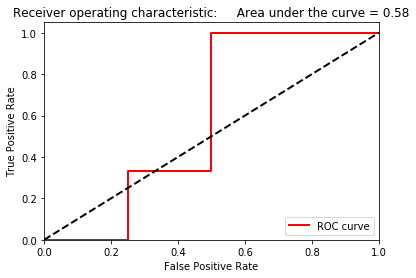

In [104]:
anomalyScoresPCA = anomalyScores(X_train, X_train_PCA_inverse)
preds = plotResults(y_train, anomalyScoresPCA, True)

In [108]:
#cutoff設定前n筆異常
preds.sort_values(by="anomalyScore",ascending=False,inplace=True)
cutoff = 2
predsTop = preds[:cutoff]
print("Precision: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/cutoff,2))
print("Recall: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/y_train.sum(),2))
print("Fraud Caught out of "+str(cutoff)+" Cases:", predsTop.trueLabel.sum())

Precision:  0.5
Recall:  0.33
Fraud Caught out of 2 Cases: 1
